In [0]:
!pip install opencv-python

  Using cached opencv_python-4.7.0.68-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-779943dd-cd75-4c1e-9988-916d247ed2c8/bin/python -m pip install --upgrade pip' command.


In [0]:
!pip install pytorch-lightning

  Using cached pytorch_lightning-1.9.0-py3-none-any.whl (825 kB)
  Using cached lightning_utilities-0.6.0.post0-py3-none-any.whl (18 kB)
  Using cached torchmetrics-0.11.1-py3-none-any.whl (517 kB)
  Using cached aiohttp-3.8.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached frozenlist-1.3.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (158 kB)
  Using cached yarl-1.8.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (264 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached multidict-6.0.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (114 kB)
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-779943dd-cd75-4c1e-9988-916d247ed2c8/bin/python -m pip install --upgrade pip' command.


In [0]:
#!pip install -U 'mlflow>=1.0.0'

In [0]:
train_path = '/dbfs/FileStore/data3a/training'
test_path = '/dbfs/FileStore/data3a/validation'


In [0]:
from torchvision.transforms import Compose, Resize, ToTensor, RandomAdjustSharpness, RandomHorizontalFlip, RandomRotation

transformed = Compose([
    Resize((224, 224)),
    #RandomHorizontalFlip(0.2),
    #RandomRotation(20),
    #RandomAdjustSharpness(sharpness_factor=2, p=0.8),
    ToTensor(),


])

Out[20]: <matplotlib.image.AxesImage at 0x7f643fe6fee0>

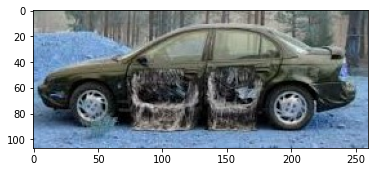

In [0]:
from PIL import Image
import os
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
random_pic = random.choice(os.listdir(train_path + '/' + '03-severe/'))
im = cv2.imread(train_path + '/03-severe/' + random_pic)
plt.imshow(im)

In [0]:
from torchvision.datasets import ImageFolder

train_folder = ImageFolder(train_path, transform=transformed)
test_folder = ImageFolder(test_path, transform=transformed)

In [0]:
from torch.utils.data import DataLoader
import numpy as np
import torch
# log batch size, learning rate, hidden layers number
# increase training set and log the number of rows of training sets, (epochs)
#dataset_subset = torch.utils.data.Subset(train_folder, np.random.choice(len(train_folder), 100, replace=False))
train_loader = DataLoader(train_folder, shuffle=True, batch_size=1)
test_loader = DataLoader(test_folder, batch_size = 64)

0
Out[23]: <matplotlib.image.AxesImage at 0x7f643fe5b400>

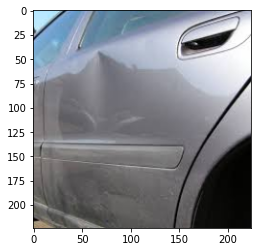

In [0]:
img, label = train_folder[0][0], train_folder[0][1]
import matplotlib.pyplot as plt
print(label)
plt.imshow(img.permute(1, 2, 0))

In [0]:
train_folder[0][0].shape

Out[24]: torch.Size([3, 224, 224])

In [0]:
import pytorch_lightning as pl
from torch import nn
from torch.optim import AdamW, SGD
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import torchmetrics
from sklearn.metrics import confusion_matrix
import mlflow
from torch.nn import CrossEntropyLoss
from torchmetrics import Accuracy
from transformers import AutoModelForImageClassification, ResNetForImageClassification, ViTForImageClassification
import torchvision.models as models
class BaseModelV0(pl.LightningModule):
  def __init__(self, learning_rate):
    super().__init__()
    #self.train_acc = torchmetrics.Accuracy(task='multiclass')
    #self.valid_acc = torchmetrics.Accuracy(task='multiclass')
    self.learning_rate = learning_rate
    self.log("learning_rate", self.learning_rate, on_epoch=True, prog_bar=True)
    '''
    self.label2id = {"01-minor": 0,
                    "02-moderate": 1,
                    "03-severe": 2}
    self.id2label = {0: "01-minor", 
                    1: "02-moderate",
                    2: "03-severe"}
    #self.feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
    self.model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224",
                                                           num_labels=3,
                                                           id2label=self.id2label,
                                                           label2id=self.label2id,
                                                           ignore_mismatched_sizes=True
                                                           )
    '''
    backbone = models.resnet50(weights="DEFAULT")
    num_filters = backbone.fc.in_features
    layers = list(backbone.children())[:-1]
    self.feature_extractor = nn.Sequential(*layers)

    # use the pretrained model to classify cifar-10 (10 image classes)
    num_target_classes = 3
    self.classifier = nn.Linear(num_filters, num_target_classes)
  def forward(self, x):
    self.feature_extractor.eval()
    with torch.no_grad():
        representations = self.feature_extractor(x).flatten(1)
    x = self.classifier(representations)
    return x

  def configure_optimizers(self):
    # lower learning rate
    # higher learning rate => 0.4, 0.5, because training loss is not converging
    optimizer = SGD(self.parameters(), lr=self.learning_rate)
    # version 12
    return optimizer

  def train_dataloader(self):
    train_dir = ImageFolder(root=train_path, transform=transformed,target_transform=None)
    train_data = DataLoader(train_dir, batch_size=64, shuffle=True)
    return train_data
  def training_step(self, train_batch, batch_idx):
      acc = 0
      X, y = train_batch
      y_pred = self(X)
      loss = CrossEntropyLoss()
      loss_fn = loss(y_pred, y)

      accuracy = Accuracy(task="multiclass", num_classes=3)
      train_acc = accuracy(y_pred, y)
    
      return {"loss": loss_fn, "train_acc": train_acc}

  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    avg_train_acc = torch.stack([x["train_acc"] for x in outputs]).mean()
    self.log("avg_train_loss", avg_train_loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log("avg_train_acc", avg_train_acc, on_step=False, on_epoch=True, prog_bar=True)

  def val_dataloader(self):
    test_dir = ImageFolder(root=test_path, transform=transformed,target_transform=None)
    test_data = DataLoader(test_dir, batch_size=64)
    return test_data
  def validation_step(self, test_batch, batch_idx):
      X, y = test_batch
      y_pred_test = self(X)
      loss = CrossEntropyLoss()
      loss_fn = loss(y_pred_test, y)
      accuracy = Accuracy("multiclass", num_classes=3)
      val_acc = accuracy(y_pred_test, y)
      
      
      return {"val_loss": loss_fn, "val_acc": val_acc}
  def validation_epoch_end(self, outputs):
    # accept list of outputs of validation loss and takes the average
    avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    avg_val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
    self.log("avg_val_loss", avg_val_loss, on_step=False, on_epoch=True, prog_bar=True)
    self.log("avg_val_acc", avg_val_acc, on_step=False, on_epoch=True, prog_bar=True)


In [0]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import mlflow

mlflow.pytorch.autolog()


# smaller dataset, more epochs
# weights adjusted every step or every batch
# accumulate batch 
early_stop_callback = EarlyStopping(monitor="avg_val_loss", patience = 50, verbose=True, mode="min", stopping_threshold=0.4)
trainer = Trainer(auto_lr_find=False, fast_dev_run=False, max_epochs=100, callbacks=[early_stop_callback], auto_scale_batch_size=False)

model = BaseModelV0(learning_rate=0.1)
#trainer.tune(model)



2023/02/04 23:52:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [0]:
import mlflow
experiment_name = "/Users/Ajay.Kamalakannan@edelmandxi.com/PyTorch_Projects/car-damage-detection-experiment"

#mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)
with mlflow.start_run() as run:
  trainer.fit(model=model)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 23.5 M
1 | classifier        | Linear     | 6.1 K 
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric avg_val_loss improved. New best score: 0.963


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric avg_val_loss improved by 0.197 >= min_delta = 0.0. New best score: 0.767


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric avg_val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.739


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric avg_val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.726


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric avg_val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.719


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [0]:
import mlflow
mlflow.__version__

Out[46]: '2.0.1'

In [0]:
from torchmetrics import Accuracy

In [0]:
model.current_epoch

Out[48]: 100

In [0]:
dir(trainer.callback_metrics)

In [0]:
dir(trainer)